# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

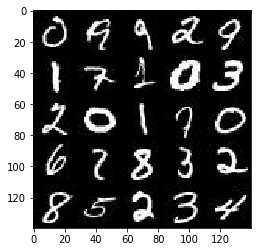

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

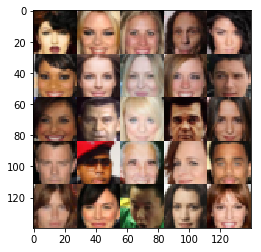

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    learning_rate = tf.placeholder(tf.float32, None,  name='learning_rate')
    return (input_real, z_data, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        images = tf.layers.conv2d(images, 64, 1, strides=2, padding='same')
        relu1 = tf.maximum(alpha * images, images)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3= tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits) 

        return output,logits 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
    
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 16x16x128
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 1, strides=2, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    saver = tf.train.Saver()    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z:batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_z : batch_z, learn_rate:learning_rate})
                                

                if steps % 10 == 0:    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriinator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriinator Loss: 0.9092 Generator Loss: 0.8812
Epoch 0/2... Discriinator Loss: 0.7176 Generator Loss: 1.1366
Epoch 0/2... Discriinator Loss: 0.6749 Generator Loss: 1.0756
Epoch 0/2... Discriinator Loss: 0.7550 Generator Loss: 0.9207
Epoch 0/2... Discriinator Loss: 0.5796 Generator Loss: 1.6181
Epoch 0/2... Discriinator Loss: 1.1026 Generator Loss: 0.5098
Epoch 0/2... Discriinator Loss: 1.1010 Generator Loss: 0.5722
Epoch 0/2... Discriinator Loss: 0.7755 Generator Loss: 0.8188
Epoch 0/2... Discriinator Loss: 0.5980 Generator Loss: 1.1491
Epoch 0/2... Discriinator Loss: 0.9089 Generator Loss: 0.7258


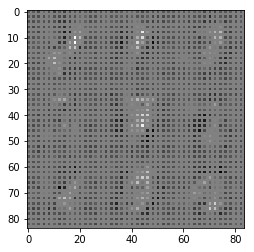

Epoch 0/2... Discriinator Loss: 0.6102 Generator Loss: 1.6517
Epoch 0/2... Discriinator Loss: 0.8653 Generator Loss: 0.8232
Epoch 0/2... Discriinator Loss: 0.7537 Generator Loss: 1.0454
Epoch 0/2... Discriinator Loss: 0.7278 Generator Loss: 1.1047
Epoch 0/2... Discriinator Loss: 0.7404 Generator Loss: 1.4778
Epoch 0/2... Discriinator Loss: 1.3539 Generator Loss: 0.3729
Epoch 0/2... Discriinator Loss: 0.7936 Generator Loss: 1.1701
Epoch 0/2... Discriinator Loss: 0.8864 Generator Loss: 1.7758
Epoch 0/2... Discriinator Loss: 0.8965 Generator Loss: 0.7316
Epoch 0/2... Discriinator Loss: 0.8239 Generator Loss: 1.0598


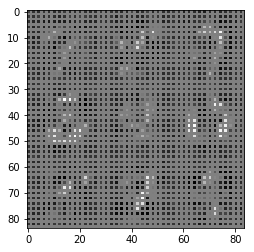

Epoch 0/2... Discriinator Loss: 1.0315 Generator Loss: 0.5867
Epoch 0/2... Discriinator Loss: 1.3072 Generator Loss: 2.6045
Epoch 0/2... Discriinator Loss: 0.9008 Generator Loss: 0.7882
Epoch 0/2... Discriinator Loss: 0.8147 Generator Loss: 0.8961
Epoch 0/2... Discriinator Loss: 1.2412 Generator Loss: 0.4784
Epoch 0/2... Discriinator Loss: 1.1138 Generator Loss: 0.5832
Epoch 0/2... Discriinator Loss: 0.8973 Generator Loss: 1.4998
Epoch 0/2... Discriinator Loss: 0.9052 Generator Loss: 0.8095
Epoch 0/2... Discriinator Loss: 0.8532 Generator Loss: 0.8187
Epoch 0/2... Discriinator Loss: 1.1394 Generator Loss: 0.5521


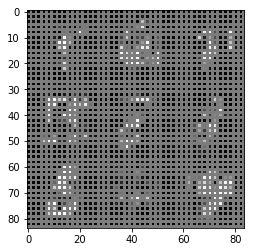

Epoch 0/2... Discriinator Loss: 0.7173 Generator Loss: 1.3862
Epoch 0/2... Discriinator Loss: 0.7323 Generator Loss: 1.4339
Epoch 0/2... Discriinator Loss: 0.8256 Generator Loss: 1.8774
Epoch 0/2... Discriinator Loss: 0.6577 Generator Loss: 1.4945
Epoch 0/2... Discriinator Loss: 0.8049 Generator Loss: 0.8196
Epoch 0/2... Discriinator Loss: 1.2994 Generator Loss: 0.4353
Epoch 0/2... Discriinator Loss: 0.8739 Generator Loss: 0.8937
Epoch 0/2... Discriinator Loss: 0.6513 Generator Loss: 1.8260
Epoch 0/2... Discriinator Loss: 0.7221 Generator Loss: 1.2530
Epoch 0/2... Discriinator Loss: 0.6771 Generator Loss: 1.0535


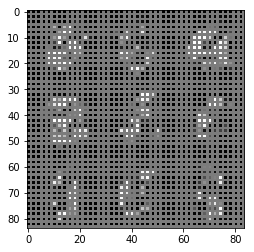

Epoch 0/2... Discriinator Loss: 0.7282 Generator Loss: 0.9636
Epoch 0/2... Discriinator Loss: 0.6921 Generator Loss: 1.0443
Epoch 0/2... Discriinator Loss: 0.7047 Generator Loss: 0.9990
Epoch 0/2... Discriinator Loss: 0.6771 Generator Loss: 1.2273
Epoch 0/2... Discriinator Loss: 0.6828 Generator Loss: 1.9113
Epoch 0/2... Discriinator Loss: 0.7456 Generator Loss: 0.9340
Epoch 0/2... Discriinator Loss: 0.7303 Generator Loss: 0.9972
Epoch 0/2... Discriinator Loss: 0.5696 Generator Loss: 1.3308
Epoch 0/2... Discriinator Loss: 0.4849 Generator Loss: 1.8576
Epoch 0/2... Discriinator Loss: 0.8497 Generator Loss: 0.7311


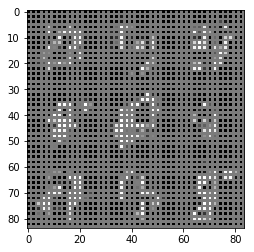

Epoch 0/2... Discriinator Loss: 0.4928 Generator Loss: 1.6911
Epoch 0/2... Discriinator Loss: 0.5341 Generator Loss: 1.2037
Epoch 0/2... Discriinator Loss: 0.4439 Generator Loss: 1.7694
Epoch 0/2... Discriinator Loss: 0.6694 Generator Loss: 2.4427
Epoch 0/2... Discriinator Loss: 0.5427 Generator Loss: 1.2987
Epoch 0/2... Discriinator Loss: 0.5126 Generator Loss: 1.4869
Epoch 0/2... Discriinator Loss: 0.4041 Generator Loss: 1.9759
Epoch 0/2... Discriinator Loss: 0.4242 Generator Loss: 1.8345
Epoch 0/2... Discriinator Loss: 0.4519 Generator Loss: 1.5495
Epoch 0/2... Discriinator Loss: 0.3855 Generator Loss: 1.7199


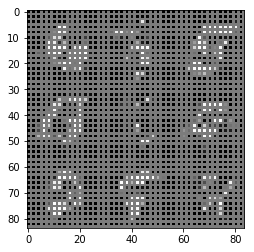

Epoch 0/2... Discriinator Loss: 0.4650 Generator Loss: 1.7311
Epoch 0/2... Discriinator Loss: 0.4657 Generator Loss: 1.4806
Epoch 0/2... Discriinator Loss: 0.3975 Generator Loss: 1.6367
Epoch 0/2... Discriinator Loss: 0.5513 Generator Loss: 1.2420
Epoch 0/2... Discriinator Loss: 0.3219 Generator Loss: 2.0925
Epoch 0/2... Discriinator Loss: 0.3622 Generator Loss: 2.0976
Epoch 0/2... Discriinator Loss: 0.3543 Generator Loss: 2.2302
Epoch 0/2... Discriinator Loss: 0.3697 Generator Loss: 1.8949
Epoch 0/2... Discriinator Loss: 0.3582 Generator Loss: 1.7853
Epoch 0/2... Discriinator Loss: 0.6972 Generator Loss: 0.8854


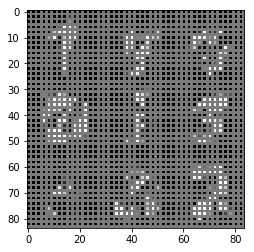

Epoch 0/2... Discriinator Loss: 0.3698 Generator Loss: 1.7388
Epoch 0/2... Discriinator Loss: 0.2987 Generator Loss: 1.9627
Epoch 0/2... Discriinator Loss: 0.2829 Generator Loss: 1.9615
Epoch 0/2... Discriinator Loss: 0.2987 Generator Loss: 2.1069
Epoch 0/2... Discriinator Loss: 0.5313 Generator Loss: 1.2566
Epoch 0/2... Discriinator Loss: 0.2904 Generator Loss: 2.1732
Epoch 0/2... Discriinator Loss: 0.3032 Generator Loss: 1.9004
Epoch 0/2... Discriinator Loss: 0.3105 Generator Loss: 2.3057
Epoch 0/2... Discriinator Loss: 0.3675 Generator Loss: 1.7218
Epoch 0/2... Discriinator Loss: 0.4100 Generator Loss: 1.4938


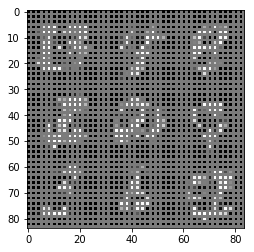

Epoch 0/2... Discriinator Loss: 0.2519 Generator Loss: 2.5873
Epoch 0/2... Discriinator Loss: 0.2022 Generator Loss: 2.4516
Epoch 0/2... Discriinator Loss: 0.3192 Generator Loss: 2.3980
Epoch 0/2... Discriinator Loss: 0.3885 Generator Loss: 1.5547
Epoch 0/2... Discriinator Loss: 0.3529 Generator Loss: 1.6446
Epoch 0/2... Discriinator Loss: 0.5117 Generator Loss: 1.1751
Epoch 0/2... Discriinator Loss: 1.3972 Generator Loss: 0.4864
Epoch 0/2... Discriinator Loss: 0.3045 Generator Loss: 1.9199
Epoch 0/2... Discriinator Loss: 0.2318 Generator Loss: 2.4969
Epoch 0/2... Discriinator Loss: 0.2342 Generator Loss: 2.2327


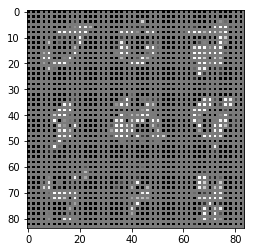

Epoch 0/2... Discriinator Loss: 0.3755 Generator Loss: 1.5542
Epoch 0/2... Discriinator Loss: 0.3381 Generator Loss: 1.6610
Epoch 0/2... Discriinator Loss: 0.2742 Generator Loss: 2.1834
Epoch 0/2... Discriinator Loss: 0.3041 Generator Loss: 1.8664
Epoch 0/2... Discriinator Loss: 0.3925 Generator Loss: 1.4584
Epoch 0/2... Discriinator Loss: 0.4430 Generator Loss: 1.3655
Epoch 0/2... Discriinator Loss: 0.2308 Generator Loss: 2.6925
Epoch 0/2... Discriinator Loss: 0.2656 Generator Loss: 2.1633
Epoch 0/2... Discriinator Loss: 0.3116 Generator Loss: 1.8382
Epoch 0/2... Discriinator Loss: 0.4926 Generator Loss: 1.3060


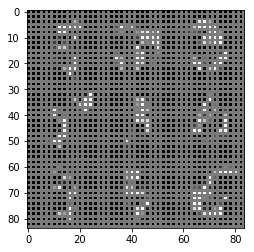

Epoch 0/2... Discriinator Loss: 0.5076 Generator Loss: 1.2069
Epoch 0/2... Discriinator Loss: 0.2601 Generator Loss: 2.0097
Epoch 0/2... Discriinator Loss: 0.2478 Generator Loss: 2.0679
Epoch 0/2... Discriinator Loss: 0.2645 Generator Loss: 2.4441
Epoch 0/2... Discriinator Loss: 0.3924 Generator Loss: 1.6334
Epoch 0/2... Discriinator Loss: 0.1800 Generator Loss: 3.4484
Epoch 0/2... Discriinator Loss: 0.2644 Generator Loss: 2.3378
Epoch 0/2... Discriinator Loss: 0.3518 Generator Loss: 1.5469
Epoch 0/2... Discriinator Loss: 0.2468 Generator Loss: 2.0075
Epoch 0/2... Discriinator Loss: 0.2686 Generator Loss: 2.3016


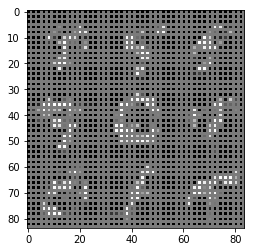

Epoch 0/2... Discriinator Loss: 0.3088 Generator Loss: 1.7414
Epoch 0/2... Discriinator Loss: 0.5611 Generator Loss: 3.9232
Epoch 0/2... Discriinator Loss: 0.3546 Generator Loss: 1.6799
Epoch 0/2... Discriinator Loss: 0.2378 Generator Loss: 2.5975
Epoch 0/2... Discriinator Loss: 0.3085 Generator Loss: 1.8861
Epoch 0/2... Discriinator Loss: 0.2222 Generator Loss: 2.8177
Epoch 0/2... Discriinator Loss: 0.1458 Generator Loss: 3.0685
Epoch 0/2... Discriinator Loss: 0.3538 Generator Loss: 3.9107
Epoch 0/2... Discriinator Loss: 0.2360 Generator Loss: 2.3129
Epoch 0/2... Discriinator Loss: 0.1354 Generator Loss: 3.2483


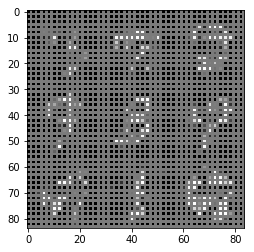

Epoch 1/2... Discriinator Loss: 0.2110 Generator Loss: 2.7648
Epoch 1/2... Discriinator Loss: 0.3253 Generator Loss: 2.0961
Epoch 1/2... Discriinator Loss: 0.2648 Generator Loss: 2.0128
Epoch 1/2... Discriinator Loss: 0.2527 Generator Loss: 2.0117
Epoch 1/2... Discriinator Loss: 0.2149 Generator Loss: 2.2224
Epoch 1/2... Discriinator Loss: 0.4659 Generator Loss: 1.3826
Epoch 1/2... Discriinator Loss: 0.3042 Generator Loss: 3.7923
Epoch 1/2... Discriinator Loss: 0.3397 Generator Loss: 1.6571
Epoch 1/2... Discriinator Loss: 0.2231 Generator Loss: 2.2440
Epoch 1/2... Discriinator Loss: 0.5717 Generator Loss: 1.1465


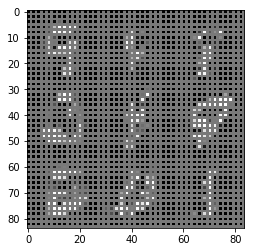

Epoch 1/2... Discriinator Loss: 0.2064 Generator Loss: 2.4808
Epoch 1/2... Discriinator Loss: 0.4560 Generator Loss: 2.8312
Epoch 1/2... Discriinator Loss: 0.3320 Generator Loss: 1.8307
Epoch 1/2... Discriinator Loss: 0.7010 Generator Loss: 0.9527
Epoch 1/2... Discriinator Loss: 0.2162 Generator Loss: 2.1349
Epoch 1/2... Discriinator Loss: 0.3223 Generator Loss: 1.7520
Epoch 1/2... Discriinator Loss: 0.1657 Generator Loss: 2.5548
Epoch 1/2... Discriinator Loss: 0.2533 Generator Loss: 2.0326
Epoch 1/2... Discriinator Loss: 0.3618 Generator Loss: 1.6159
Epoch 1/2... Discriinator Loss: 0.2973 Generator Loss: 1.8988


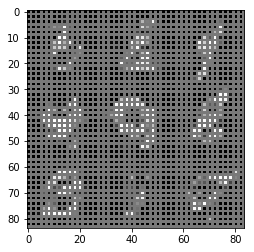

Epoch 1/2... Discriinator Loss: 0.3284 Generator Loss: 2.9570
Epoch 1/2... Discriinator Loss: 0.4511 Generator Loss: 1.3527
Epoch 1/2... Discriinator Loss: 0.3399 Generator Loss: 1.6789
Epoch 1/2... Discriinator Loss: 0.3296 Generator Loss: 1.7264
Epoch 1/2... Discriinator Loss: 0.4877 Generator Loss: 1.2997
Epoch 1/2... Discriinator Loss: 0.3763 Generator Loss: 1.5589
Epoch 1/2... Discriinator Loss: 0.2399 Generator Loss: 2.2281
Epoch 1/2... Discriinator Loss: 0.5769 Generator Loss: 1.2082
Epoch 1/2... Discriinator Loss: 0.2887 Generator Loss: 2.9067
Epoch 1/2... Discriinator Loss: 0.3086 Generator Loss: 1.8414


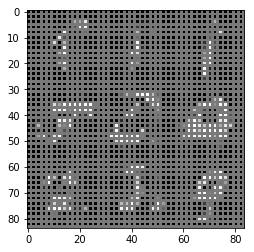

Epoch 1/2... Discriinator Loss: 0.2881 Generator Loss: 1.9406
Epoch 1/2... Discriinator Loss: 0.3671 Generator Loss: 1.6292
Epoch 1/2... Discriinator Loss: 0.2786 Generator Loss: 3.2699
Epoch 1/2... Discriinator Loss: 0.3413 Generator Loss: 1.7779
Epoch 1/2... Discriinator Loss: 0.3123 Generator Loss: 1.8635
Epoch 1/2... Discriinator Loss: 0.3896 Generator Loss: 1.9759
Epoch 1/2... Discriinator Loss: 0.3123 Generator Loss: 2.0903
Epoch 1/2... Discriinator Loss: 0.2896 Generator Loss: 1.7976
Epoch 1/2... Discriinator Loss: 1.0383 Generator Loss: 3.8900
Epoch 1/2... Discriinator Loss: 0.3956 Generator Loss: 1.6491


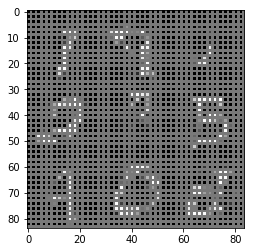

Epoch 1/2... Discriinator Loss: 0.2808 Generator Loss: 2.4349
Epoch 1/2... Discriinator Loss: 0.3896 Generator Loss: 1.6944
Epoch 1/2... Discriinator Loss: 0.4575 Generator Loss: 1.4326
Epoch 1/2... Discriinator Loss: 0.7525 Generator Loss: 0.9119
Epoch 1/2... Discriinator Loss: 0.9153 Generator Loss: 0.7922
Epoch 1/2... Discriinator Loss: 0.5695 Generator Loss: 1.0939
Epoch 1/2... Discriinator Loss: 0.3556 Generator Loss: 1.8164
Epoch 1/2... Discriinator Loss: 0.5467 Generator Loss: 1.0909
Epoch 1/2... Discriinator Loss: 0.9874 Generator Loss: 0.6478
Epoch 1/2... Discriinator Loss: 0.4115 Generator Loss: 1.4686


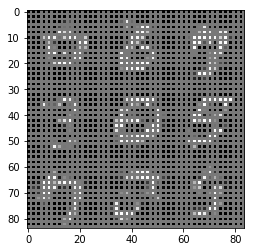

Epoch 1/2... Discriinator Loss: 0.2992 Generator Loss: 2.0068
Epoch 1/2... Discriinator Loss: 0.4899 Generator Loss: 1.1810
Epoch 1/2... Discriinator Loss: 0.3251 Generator Loss: 1.6858
Epoch 1/2... Discriinator Loss: 0.7731 Generator Loss: 0.8477
Epoch 1/2... Discriinator Loss: 0.3845 Generator Loss: 1.5502
Epoch 1/2... Discriinator Loss: 0.3419 Generator Loss: 1.9589
Epoch 1/2... Discriinator Loss: 0.2197 Generator Loss: 2.4476
Epoch 1/2... Discriinator Loss: 0.4319 Generator Loss: 3.3248
Epoch 1/2... Discriinator Loss: 0.2889 Generator Loss: 2.2408
Epoch 1/2... Discriinator Loss: 0.5033 Generator Loss: 1.2861


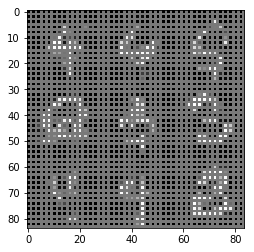

Epoch 1/2... Discriinator Loss: 0.3781 Generator Loss: 1.7273
Epoch 1/2... Discriinator Loss: 0.3890 Generator Loss: 1.6083
Epoch 1/2... Discriinator Loss: 0.5136 Generator Loss: 1.2396
Epoch 1/2... Discriinator Loss: 0.6730 Generator Loss: 0.9641
Epoch 1/2... Discriinator Loss: 0.3223 Generator Loss: 2.3005
Epoch 1/2... Discriinator Loss: 0.3223 Generator Loss: 2.1669
Epoch 1/2... Discriinator Loss: 0.4694 Generator Loss: 1.3151
Epoch 1/2... Discriinator Loss: 0.7975 Generator Loss: 4.4174
Epoch 1/2... Discriinator Loss: 0.6033 Generator Loss: 1.0655
Epoch 1/2... Discriinator Loss: 0.5054 Generator Loss: 1.2991


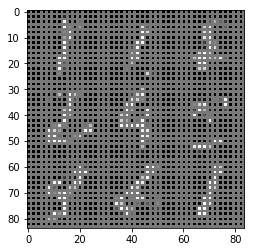

Epoch 1/2... Discriinator Loss: 0.4867 Generator Loss: 1.2666
Epoch 1/2... Discriinator Loss: 0.3379 Generator Loss: 1.8203
Epoch 1/2... Discriinator Loss: 0.8871 Generator Loss: 0.7030
Epoch 1/2... Discriinator Loss: 0.3152 Generator Loss: 1.9795
Epoch 1/2... Discriinator Loss: 0.5626 Generator Loss: 1.1673
Epoch 1/2... Discriinator Loss: 0.2417 Generator Loss: 2.2197
Epoch 1/2... Discriinator Loss: 0.3603 Generator Loss: 1.7468
Epoch 1/2... Discriinator Loss: 0.5022 Generator Loss: 1.2560
Epoch 1/2... Discriinator Loss: 1.1036 Generator Loss: 0.5429
Epoch 1/2... Discriinator Loss: 0.5172 Generator Loss: 1.3465


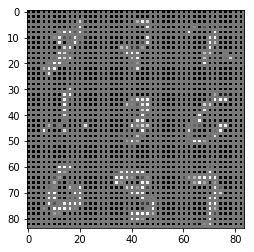

Epoch 1/2... Discriinator Loss: 0.3559 Generator Loss: 3.3353
Epoch 1/2... Discriinator Loss: 0.3299 Generator Loss: 2.6371
Epoch 1/2... Discriinator Loss: 0.3188 Generator Loss: 1.7570
Epoch 1/2... Discriinator Loss: 0.6293 Generator Loss: 1.0349
Epoch 1/2... Discriinator Loss: 0.6356 Generator Loss: 1.0885
Epoch 1/2... Discriinator Loss: 1.2185 Generator Loss: 0.4862
Epoch 1/2... Discriinator Loss: 0.7167 Generator Loss: 0.9741
Epoch 1/2... Discriinator Loss: 0.4340 Generator Loss: 1.5482
Epoch 1/2... Discriinator Loss: 0.3692 Generator Loss: 1.7163
Epoch 1/2... Discriinator Loss: 0.4442 Generator Loss: 1.5700


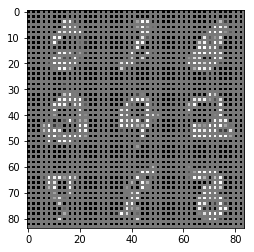

Epoch 1/2... Discriinator Loss: 0.4629 Generator Loss: 2.0872
Epoch 1/2... Discriinator Loss: 0.4134 Generator Loss: 1.5265
Epoch 1/2... Discriinator Loss: 0.4430 Generator Loss: 1.3964
Epoch 1/2... Discriinator Loss: 0.4059 Generator Loss: 1.4319
Epoch 1/2... Discriinator Loss: 0.4219 Generator Loss: 1.4476
Epoch 1/2... Discriinator Loss: 0.6103 Generator Loss: 1.1114
Epoch 1/2... Discriinator Loss: 0.3211 Generator Loss: 2.0596
Epoch 1/2... Discriinator Loss: 0.5178 Generator Loss: 1.2474
Epoch 1/2... Discriinator Loss: 0.4775 Generator Loss: 1.3059
Epoch 1/2... Discriinator Loss: 0.5930 Generator Loss: 1.1277


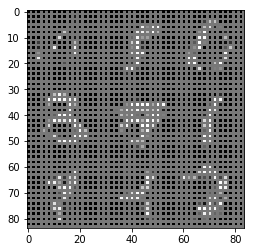

Epoch 1/2... Discriinator Loss: 1.5595 Generator Loss: 0.3689
Epoch 1/2... Discriinator Loss: 0.2883 Generator Loss: 1.9196
Epoch 1/2... Discriinator Loss: 0.4781 Generator Loss: 1.3589
Epoch 1/2... Discriinator Loss: 0.4821 Generator Loss: 1.2971
Epoch 1/2... Discriinator Loss: 0.1668 Generator Loss: 3.1932
Epoch 1/2... Discriinator Loss: 0.4224 Generator Loss: 1.5094
Epoch 1/2... Discriinator Loss: 0.4677 Generator Loss: 1.3414
Epoch 1/2... Discriinator Loss: 0.3520 Generator Loss: 1.7858
Epoch 1/2... Discriinator Loss: 0.5181 Generator Loss: 1.1611
Epoch 1/2... Discriinator Loss: 0.4847 Generator Loss: 1.2610


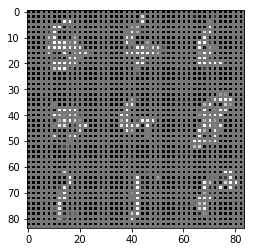

Epoch 1/2... Discriinator Loss: 0.5614 Generator Loss: 1.1807
Epoch 1/2... Discriinator Loss: 0.3651 Generator Loss: 1.9417
Epoch 1/2... Discriinator Loss: 0.7712 Generator Loss: 0.8036
Epoch 1/2... Discriinator Loss: 0.3490 Generator Loss: 1.7990
Epoch 1/2... Discriinator Loss: 0.2541 Generator Loss: 2.2354
Epoch 1/2... Discriinator Loss: 0.2923 Generator Loss: 2.5198
Epoch 1/2... Discriinator Loss: 0.6101 Generator Loss: 1.0837
Epoch 1/2... Discriinator Loss: 0.4112 Generator Loss: 2.1417
Epoch 1/2... Discriinator Loss: 0.6224 Generator Loss: 1.1286
Epoch 1/2... Discriinator Loss: 0.2413 Generator Loss: 2.0752


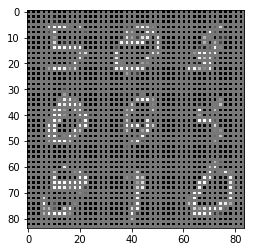

In [ ]:
batch_size = 50
z_dim = 60
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriinator Loss: 0.2947 Generator Loss: 3.8112
Epoch 0/1... Discriinator Loss: 1.4530 Generator Loss: 6.6037
Epoch 0/1... Discriinator Loss: 0.3009 Generator Loss: 6.0670
Epoch 0/1... Discriinator Loss: 1.3032 Generator Loss: 11.7285
Epoch 0/1... Discriinator Loss: 0.1405 Generator Loss: 3.4234
Epoch 0/1... Discriinator Loss: 0.1721 Generator Loss: 7.1039
Epoch 0/1... Discriinator Loss: 0.0961 Generator Loss: 7.6272
Epoch 0/1... Discriinator Loss: 0.1512 Generator Loss: 3.1159
Epoch 0/1... Discriinator Loss: 0.0488 Generator Loss: 4.7028
Epoch 0/1... Discriinator Loss: 0.0265 Generator Loss: 5.2832


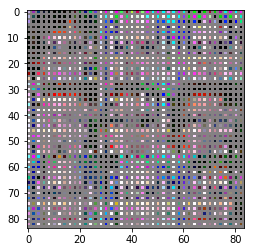

Epoch 0/1... Discriinator Loss: 1.4733 Generator Loss: 2.4020
Epoch 0/1... Discriinator Loss: 0.7772 Generator Loss: 1.2788
Epoch 0/1... Discriinator Loss: 1.2199 Generator Loss: 0.5464
Epoch 0/1... Discriinator Loss: 1.4802 Generator Loss: 0.5594
Epoch 0/1... Discriinator Loss: 0.5627 Generator Loss: 4.4174
Epoch 0/1... Discriinator Loss: 1.4551 Generator Loss: 3.7938
Epoch 0/1... Discriinator Loss: 0.9948 Generator Loss: 0.7547
Epoch 0/1... Discriinator Loss: 1.4071 Generator Loss: 3.1794
Epoch 0/1... Discriinator Loss: 0.9188 Generator Loss: 0.6357
Epoch 0/1... Discriinator Loss: 1.1957 Generator Loss: 0.6033


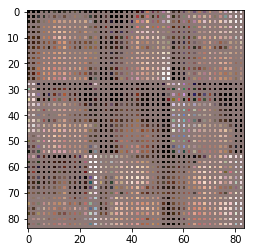

Epoch 0/1... Discriinator Loss: 1.2005 Generator Loss: 0.4523
Epoch 0/1... Discriinator Loss: 0.1770 Generator Loss: 2.3160
Epoch 0/1... Discriinator Loss: 1.1676 Generator Loss: 2.3479
Epoch 0/1... Discriinator Loss: 0.0999 Generator Loss: 3.5579
Epoch 0/1... Discriinator Loss: 2.2968 Generator Loss: 0.1713
Epoch 0/1... Discriinator Loss: 0.3173 Generator Loss: 2.6044
Epoch 0/1... Discriinator Loss: 0.2120 Generator Loss: 2.2153
Epoch 0/1... Discriinator Loss: 2.8282 Generator Loss: 8.4093
Epoch 0/1... Discriinator Loss: 1.4498 Generator Loss: 2.3033
Epoch 0/1... Discriinator Loss: 1.2474 Generator Loss: 0.6437


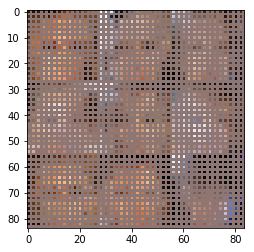

Epoch 0/1... Discriinator Loss: 0.2040 Generator Loss: 2.1756
Epoch 0/1... Discriinator Loss: 0.7896 Generator Loss: 0.9111
Epoch 0/1... Discriinator Loss: 1.0682 Generator Loss: 0.5654
Epoch 0/1... Discriinator Loss: 0.5725 Generator Loss: 3.4442
Epoch 0/1... Discriinator Loss: 0.4175 Generator Loss: 5.1566
Epoch 0/1... Discriinator Loss: 0.7869 Generator Loss: 1.2610
Epoch 0/1... Discriinator Loss: 1.4315 Generator Loss: 5.2828
Epoch 0/1... Discriinator Loss: 2.1184 Generator Loss: 0.1782
Epoch 0/1... Discriinator Loss: 0.6229 Generator Loss: 3.6581
Epoch 0/1... Discriinator Loss: 1.0747 Generator Loss: 0.6521


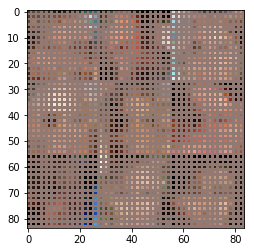

Epoch 0/1... Discriinator Loss: 0.7869 Generator Loss: 1.0437
Epoch 0/1... Discriinator Loss: 0.2742 Generator Loss: 3.3694
Epoch 0/1... Discriinator Loss: 1.1124 Generator Loss: 0.5785
Epoch 0/1... Discriinator Loss: 0.9701 Generator Loss: 0.7131
Epoch 0/1... Discriinator Loss: 1.6133 Generator Loss: 0.3552
Epoch 0/1... Discriinator Loss: 0.4172 Generator Loss: 2.5143
Epoch 0/1... Discriinator Loss: 0.2077 Generator Loss: 4.4403
Epoch 0/1... Discriinator Loss: 1.9115 Generator Loss: 0.2951
Epoch 0/1... Discriinator Loss: 1.3330 Generator Loss: 0.4712
Epoch 0/1... Discriinator Loss: 1.0723 Generator Loss: 2.5453


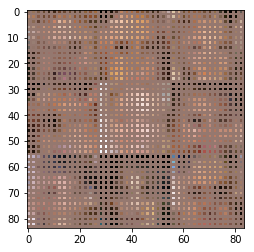

Epoch 0/1... Discriinator Loss: 0.4650 Generator Loss: 1.4474
Epoch 0/1... Discriinator Loss: 1.4217 Generator Loss: 0.6902
Epoch 0/1... Discriinator Loss: 0.6421 Generator Loss: 4.6044
Epoch 0/1... Discriinator Loss: 0.5435 Generator Loss: 2.5396
Epoch 0/1... Discriinator Loss: 0.6955 Generator Loss: 1.0602
Epoch 0/1... Discriinator Loss: 1.1815 Generator Loss: 0.5511
Epoch 0/1... Discriinator Loss: 0.3878 Generator Loss: 2.9958
Epoch 0/1... Discriinator Loss: 0.7726 Generator Loss: 1.6198
Epoch 0/1... Discriinator Loss: 2.1190 Generator Loss: 0.1961
Epoch 0/1... Discriinator Loss: 2.4339 Generator Loss: 0.1927


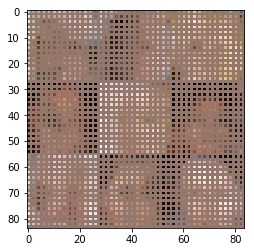

Epoch 0/1... Discriinator Loss: 0.7148 Generator Loss: 0.8942
Epoch 0/1... Discriinator Loss: 1.2312 Generator Loss: 0.7507
Epoch 0/1... Discriinator Loss: 1.2761 Generator Loss: 0.8297
Epoch 0/1... Discriinator Loss: 0.9066 Generator Loss: 1.8215
Epoch 0/1... Discriinator Loss: 0.9759 Generator Loss: 1.1790
Epoch 0/1... Discriinator Loss: 1.5720 Generator Loss: 0.4516
Epoch 0/1... Discriinator Loss: 0.9668 Generator Loss: 1.0342
Epoch 0/1... Discriinator Loss: 1.5720 Generator Loss: 0.5769
Epoch 0/1... Discriinator Loss: 1.7954 Generator Loss: 0.6676
Epoch 0/1... Discriinator Loss: 1.3398 Generator Loss: 0.7856


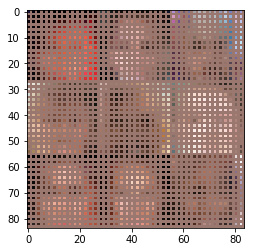

Epoch 0/1... Discriinator Loss: 1.3053 Generator Loss: 0.8961
Epoch 0/1... Discriinator Loss: 1.1068 Generator Loss: 0.9234
Epoch 0/1... Discriinator Loss: 0.9409 Generator Loss: 1.3726
Epoch 0/1... Discriinator Loss: 1.5598 Generator Loss: 0.4485
Epoch 0/1... Discriinator Loss: 1.2786 Generator Loss: 1.1040
Epoch 0/1... Discriinator Loss: 0.8847 Generator Loss: 1.1087
Epoch 0/1... Discriinator Loss: 1.1620 Generator Loss: 0.9048
Epoch 0/1... Discriinator Loss: 1.0628 Generator Loss: 0.9816
Epoch 0/1... Discriinator Loss: 1.2562 Generator Loss: 1.5938
Epoch 0/1... Discriinator Loss: 1.3785 Generator Loss: 0.9882


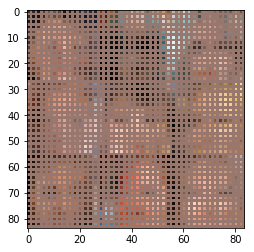

Epoch 0/1... Discriinator Loss: 1.2122 Generator Loss: 1.1363
Epoch 0/1... Discriinator Loss: 1.0084 Generator Loss: 0.7253
Epoch 0/1... Discriinator Loss: 1.0395 Generator Loss: 0.8594
Epoch 0/1... Discriinator Loss: 1.4561 Generator Loss: 0.6215
Epoch 0/1... Discriinator Loss: 1.4195 Generator Loss: 1.1656
Epoch 0/1... Discriinator Loss: 1.0984 Generator Loss: 0.6178
Epoch 0/1... Discriinator Loss: 1.0706 Generator Loss: 0.9435
Epoch 0/1... Discriinator Loss: 0.8262 Generator Loss: 0.9973
Epoch 0/1... Discriinator Loss: 1.0254 Generator Loss: 1.1367
Epoch 0/1... Discriinator Loss: 1.1958 Generator Loss: 0.7427


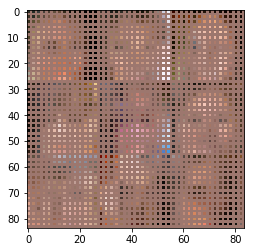

Epoch 0/1... Discriinator Loss: 1.8058 Generator Loss: 0.6467
Epoch 0/1... Discriinator Loss: 1.0869 Generator Loss: 0.7916
Epoch 0/1... Discriinator Loss: 1.0954 Generator Loss: 0.9042
Epoch 0/1... Discriinator Loss: 1.1477 Generator Loss: 0.7267
Epoch 0/1... Discriinator Loss: 1.2506 Generator Loss: 0.5693
Epoch 0/1... Discriinator Loss: 1.0958 Generator Loss: 0.8470
Epoch 0/1... Discriinator Loss: 1.1502 Generator Loss: 0.8335
Epoch 0/1... Discriinator Loss: 1.1246 Generator Loss: 0.9032
Epoch 0/1... Discriinator Loss: 1.3631 Generator Loss: 0.5996
Epoch 0/1... Discriinator Loss: 1.1799 Generator Loss: 0.7991


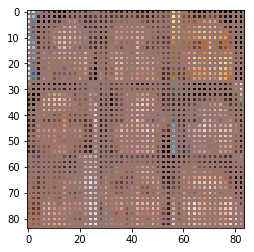

Epoch 0/1... Discriinator Loss: 1.3180 Generator Loss: 0.7086
Epoch 0/1... Discriinator Loss: 1.4077 Generator Loss: 0.9283
Epoch 0/1... Discriinator Loss: 0.9689 Generator Loss: 1.0542
Epoch 0/1... Discriinator Loss: 1.2662 Generator Loss: 0.8587
Epoch 0/1... Discriinator Loss: 1.3180 Generator Loss: 0.9021
Epoch 0/1... Discriinator Loss: 1.1545 Generator Loss: 0.5649
Epoch 0/1... Discriinator Loss: 1.2785 Generator Loss: 0.8374
Epoch 0/1... Discriinator Loss: 1.4777 Generator Loss: 0.4953
Epoch 0/1... Discriinator Loss: 0.9786 Generator Loss: 1.1636
Epoch 0/1... Discriinator Loss: 1.2358 Generator Loss: 0.8075


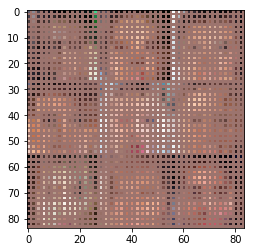

Epoch 0/1... Discriinator Loss: 1.3396 Generator Loss: 0.7049
Epoch 0/1... Discriinator Loss: 1.0683 Generator Loss: 0.9025
Epoch 0/1... Discriinator Loss: 1.3221 Generator Loss: 0.6791
Epoch 0/1... Discriinator Loss: 0.9392 Generator Loss: 1.3991
Epoch 0/1... Discriinator Loss: 1.3763 Generator Loss: 0.9345
Epoch 0/1... Discriinator Loss: 1.5243 Generator Loss: 0.3865
Epoch 0/1... Discriinator Loss: 1.0751 Generator Loss: 0.7588
Epoch 0/1... Discriinator Loss: 1.0706 Generator Loss: 1.3450
Epoch 0/1... Discriinator Loss: 1.4188 Generator Loss: 0.4218
Epoch 0/1... Discriinator Loss: 1.2988 Generator Loss: 0.7588


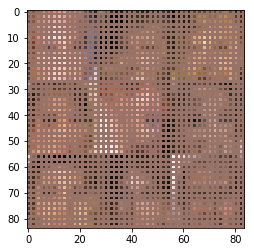

Epoch 0/1... Discriinator Loss: 0.7136 Generator Loss: 0.9274
Epoch 0/1... Discriinator Loss: 0.4261 Generator Loss: 2.0402
Epoch 0/1... Discriinator Loss: 0.6678 Generator Loss: 2.8579
Epoch 0/1... Discriinator Loss: 0.2315 Generator Loss: 2.7317
Epoch 0/1... Discriinator Loss: 0.3915 Generator Loss: 2.4774
Epoch 0/1... Discriinator Loss: 0.6428 Generator Loss: 2.8783
Epoch 0/1... Discriinator Loss: 0.9106 Generator Loss: 2.0411
Epoch 0/1... Discriinator Loss: 0.1335 Generator Loss: 3.1675
Epoch 0/1... Discriinator Loss: 0.7145 Generator Loss: 0.9836
Epoch 0/1... Discriinator Loss: 0.4792 Generator Loss: 1.1839


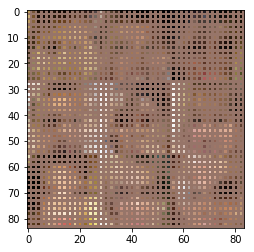

Epoch 0/1... Discriinator Loss: 0.2412 Generator Loss: 2.7286
Epoch 0/1... Discriinator Loss: 2.8662 Generator Loss: 0.1191
Epoch 0/1... Discriinator Loss: 0.5145 Generator Loss: 3.4989
Epoch 0/1... Discriinator Loss: 0.6282 Generator Loss: 1.1381
Epoch 0/1... Discriinator Loss: 0.2047 Generator Loss: 2.2833
Epoch 0/1... Discriinator Loss: 0.5543 Generator Loss: 3.5714
Epoch 0/1... Discriinator Loss: 1.2031 Generator Loss: 0.9138
Epoch 0/1... Discriinator Loss: 1.6377 Generator Loss: 1.6760
Epoch 0/1... Discriinator Loss: 1.3656 Generator Loss: 0.4046
Epoch 0/1... Discriinator Loss: 1.4487 Generator Loss: 0.4235


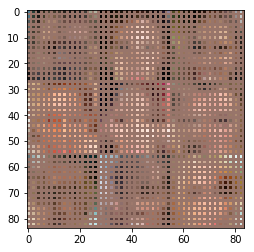

Epoch 0/1... Discriinator Loss: 0.7066 Generator Loss: 3.1130
Epoch 0/1... Discriinator Loss: 0.5184 Generator Loss: 2.8455
Epoch 0/1... Discriinator Loss: 0.5754 Generator Loss: 2.9378
Epoch 0/1... Discriinator Loss: 0.6190 Generator Loss: 1.6339
Epoch 0/1... Discriinator Loss: 0.3992 Generator Loss: 5.1442
Epoch 0/1... Discriinator Loss: 0.1121 Generator Loss: 2.8838
Epoch 0/1... Discriinator Loss: 0.1545 Generator Loss: 4.0590
Epoch 0/1... Discriinator Loss: 0.3454 Generator Loss: 2.7714
Epoch 0/1... Discriinator Loss: 0.4820 Generator Loss: 5.0310
Epoch 0/1... Discriinator Loss: 0.6714 Generator Loss: 1.0809


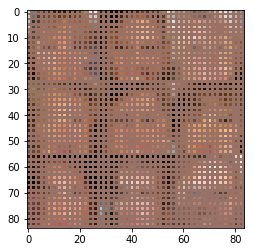

Epoch 0/1... Discriinator Loss: 0.4893 Generator Loss: 1.3573
Epoch 0/1... Discriinator Loss: 1.4972 Generator Loss: 0.3838
Epoch 0/1... Discriinator Loss: 0.5732 Generator Loss: 1.1049
Epoch 0/1... Discriinator Loss: 1.4682 Generator Loss: 1.4262
Epoch 0/1... Discriinator Loss: 0.4218 Generator Loss: 1.6574
Epoch 0/1... Discriinator Loss: 0.1401 Generator Loss: 4.7991
Epoch 0/1... Discriinator Loss: 1.2613 Generator Loss: 0.8300
Epoch 0/1... Discriinator Loss: 1.9095 Generator Loss: 0.2948
Epoch 0/1... Discriinator Loss: 1.0868 Generator Loss: 2.0931
Epoch 0/1... Discriinator Loss: 0.6553 Generator Loss: 2.9835


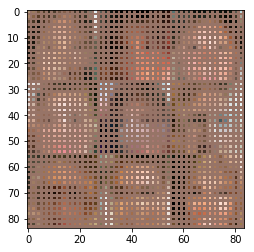

Epoch 0/1... Discriinator Loss: 1.0799 Generator Loss: 0.8578
Epoch 0/1... Discriinator Loss: 1.1938 Generator Loss: 2.4887
Epoch 0/1... Discriinator Loss: 0.3662 Generator Loss: 3.4341
Epoch 0/1... Discriinator Loss: 0.6710 Generator Loss: 1.2145
Epoch 0/1... Discriinator Loss: 0.8266 Generator Loss: 4.1382
Epoch 0/1... Discriinator Loss: 0.1550 Generator Loss: 3.0249
Epoch 0/1... Discriinator Loss: 0.4223 Generator Loss: 1.5456
Epoch 0/1... Discriinator Loss: 1.6246 Generator Loss: 1.8131
Epoch 0/1... Discriinator Loss: 0.5466 Generator Loss: 2.7294
Epoch 0/1... Discriinator Loss: 0.3894 Generator Loss: 2.1158


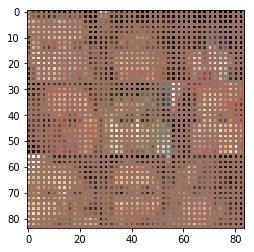

Epoch 0/1... Discriinator Loss: 2.1595 Generator Loss: 0.2030
Epoch 0/1... Discriinator Loss: 0.5782 Generator Loss: 2.7919
Epoch 0/1... Discriinator Loss: 0.4109 Generator Loss: 2.6977
Epoch 0/1... Discriinator Loss: 0.4356 Generator Loss: 2.6686
Epoch 0/1... Discriinator Loss: 1.0368 Generator Loss: 0.6855
Epoch 0/1... Discriinator Loss: 0.2587 Generator Loss: 3.8416
Epoch 0/1... Discriinator Loss: 0.5833 Generator Loss: 1.2337
Epoch 0/1... Discriinator Loss: 0.4330 Generator Loss: 1.6929
Epoch 0/1... Discriinator Loss: 2.1769 Generator Loss: 0.1922
Epoch 0/1... Discriinator Loss: 1.2119 Generator Loss: 4.7471


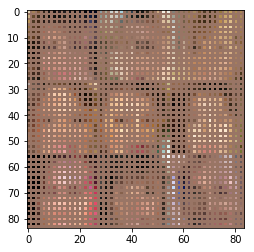

Epoch 0/1... Discriinator Loss: 0.5015 Generator Loss: 1.2227
Epoch 0/1... Discriinator Loss: 0.3137 Generator Loss: 2.9226
Epoch 0/1... Discriinator Loss: 1.3199 Generator Loss: 0.6479
Epoch 0/1... Discriinator Loss: 1.5054 Generator Loss: 0.4163
Epoch 0/1... Discriinator Loss: 2.4445 Generator Loss: 0.3260
Epoch 0/1... Discriinator Loss: 0.9984 Generator Loss: 0.6612
Epoch 0/1... Discriinator Loss: 0.6098 Generator Loss: 2.1123
Epoch 0/1... Discriinator Loss: 1.1950 Generator Loss: 0.9293
Epoch 0/1... Discriinator Loss: 0.7578 Generator Loss: 0.8132
Epoch 0/1... Discriinator Loss: 0.5400 Generator Loss: 2.2163


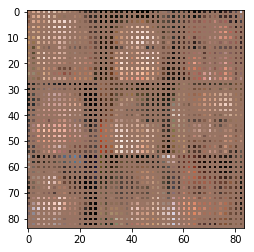

Epoch 0/1... Discriinator Loss: 0.7911 Generator Loss: 0.8369
Epoch 0/1... Discriinator Loss: 0.2264 Generator Loss: 3.4217
Epoch 0/1... Discriinator Loss: 1.2743 Generator Loss: 5.5514
Epoch 0/1... Discriinator Loss: 1.4092 Generator Loss: 0.4654
Epoch 0/1... Discriinator Loss: 1.4658 Generator Loss: 0.4440
Epoch 0/1... Discriinator Loss: 1.5568 Generator Loss: 0.4921
Epoch 0/1... Discriinator Loss: 0.6745 Generator Loss: 0.9359
Epoch 0/1... Discriinator Loss: 2.4111 Generator Loss: 0.1713
Epoch 0/1... Discriinator Loss: 0.8558 Generator Loss: 0.9619
Epoch 0/1... Discriinator Loss: 0.3036 Generator Loss: 2.2083


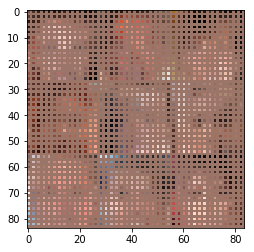

Epoch 0/1... Discriinator Loss: 0.2433 Generator Loss: 3.8060
Epoch 0/1... Discriinator Loss: 0.2578 Generator Loss: 2.7991
Epoch 0/1... Discriinator Loss: 0.2374 Generator Loss: 3.9791
Epoch 0/1... Discriinator Loss: 0.0416 Generator Loss: 4.7739
Epoch 0/1... Discriinator Loss: 0.8143 Generator Loss: 1.8577
Epoch 0/1... Discriinator Loss: 0.5741 Generator Loss: 1.7843
Epoch 0/1... Discriinator Loss: 1.0961 Generator Loss: 0.6396
Epoch 0/1... Discriinator Loss: 1.5747 Generator Loss: 0.3958
Epoch 0/1... Discriinator Loss: 0.1928 Generator Loss: 3.4817
Epoch 0/1... Discriinator Loss: 0.4521 Generator Loss: 1.2810


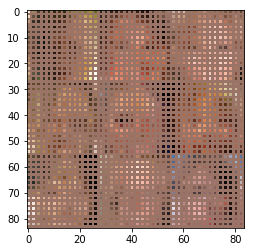

Epoch 0/1... Discriinator Loss: 0.4333 Generator Loss: 2.0729
Epoch 0/1... Discriinator Loss: 0.5069 Generator Loss: 1.3567
Epoch 0/1... Discriinator Loss: 0.9531 Generator Loss: 0.7960
Epoch 0/1... Discriinator Loss: 0.3647 Generator Loss: 1.9417
Epoch 0/1... Discriinator Loss: 0.1544 Generator Loss: 3.0215
Epoch 0/1... Discriinator Loss: 0.8010 Generator Loss: 6.2616
Epoch 0/1... Discriinator Loss: 0.5489 Generator Loss: 2.8916
Epoch 0/1... Discriinator Loss: 0.3890 Generator Loss: 1.7760
Epoch 0/1... Discriinator Loss: 2.2056 Generator Loss: 0.1589
Epoch 0/1... Discriinator Loss: 0.3046 Generator Loss: 1.8913


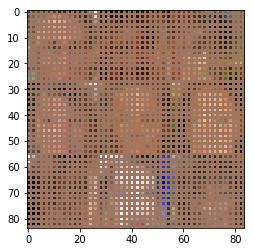

Epoch 0/1... Discriinator Loss: 1.3920 Generator Loss: 0.5496
Epoch 0/1... Discriinator Loss: 0.3523 Generator Loss: 4.3332
Epoch 0/1... Discriinator Loss: 0.5244 Generator Loss: 2.1246
Epoch 0/1... Discriinator Loss: 1.6079 Generator Loss: 0.5523
Epoch 0/1... Discriinator Loss: 0.8232 Generator Loss: 1.2182


In [ ]:
batch_size = 64
z_dim = 50
learning_rate = 0.004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.